# Churn Prediction with PySpark

The studied classifiers used are:
* Logistic regression
* Naive Bayes
* Linear Support Vector Machine
* Decision tree classifier
* Random forest classifier
* Gradient-boosted tree classifier


The table of contents is the following:

1. [Initializing a Spark session](#t1.)
2. [Fetching and Importing Churn Data](#t2.)
3. [Summary Statistics](#t3.)
4. [Correlations and Data Preparation](#t4.)
5. [Using Spark **MLlib** Package](#t5.)
    * 5.1. [Decision Tree Models](#t5.1.)
    * 5.2. [Model Training](#t5.2.)
    * 5.3. [Model Evaluation](#t5.3.)
    * 5.4. [Stratified Sampling](#t5.4.)
6. [Using Spark **ML** Package](#t6.)
    * 6.1. [Pipelining](#t6.1.)
    * 6.2. [Model Selection](#t6.2.)
    * 6.3. [K-fold cross validation](#t6.3.)
    * 6.4. [Model Evaluation](#t6.4.)
7. [Conclusion](#t7.)

<a id="t1."></a>
## 1. Initializing a Spark session

In [ ]:
# Upgrading pip
! python3 -m pip install --upgrade pip
# Downloading pyspark library
! pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 21.9 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 23.1.2
    Uninstalling pip-23.1.2:
      Successfully uninstalled pip-23.1.2


In [ ]:
# Importing and configuration of Spark Session
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("Churn Prediction with PySpark").getOrCreate()

<a id="t2."></a>
## 2. Fetching and Importing Churn Data

Dataset used is the Orange Telecoms Churn Dataset. It consists of cleaned customer activity data (features), along with a churn label specifying whether the customer canceled their subscription or not.

The two sets from the same batch are used, but have been split by an 80/20 ratio. Using larger set for training and cross-validation purposes, and the smaller set for final testing and model performance evaluation.


In [ ]:
import os
csv_path = []
for dirname, _, filenames in os.walk('/home/dataset'):
    for filename in filenames:
        csv_path.append(os.path.join(dirname, filename))
print(csv_path)

['/home/dataset/churn-bigml-80.csv', '/home/dataset/churn-bigml-20.csv']


In [ ]:
CV_data = spark.read.csv(csv_path[0], header='true', inferSchema='true')

final_test_data = spark.read.csv(csv_path[1], header='true', inferSchema='true')

CV_data.printSchema()

root
 |-- State: string (nullable = true)
 |-- Account length: integer (nullable = true)
 |-- Area code: integer (nullable = true)
 |-- International plan: string (nullable = true)
 |-- Voice mail plan: string (nullable = true)
 |-- Number vmail messages: integer (nullable = true)
 |-- Total day minutes: double (nullable = true)
 |-- Total day calls: integer (nullable = true)
 |-- Total day charge: double (nullable = true)
 |-- Total eve minutes: double (nullable = true)
 |-- Total eve calls: integer (nullable = true)
 |-- Total eve charge: double (nullable = true)
 |-- Total night minutes: double (nullable = true)
 |-- Total night calls: integer (nullable = true)
 |-- Total night charge: double (nullable = true)
 |-- Total intl minutes: double (nullable = true)
 |-- Total intl calls: integer (nullable = true)
 |-- Total intl charge: double (nullable = true)
 |-- Customer service calls: integer (nullable = true)
 |-- Churn: boolean (nullable = true)



In [ ]:
print("The training dataset contains {} samples.".format(CV_data.count()))
print("The test dataset contains {} samples.".format(final_test_data.count()))

The training dataset contains 2666 samples.
The test dataset contains 667 samples.


Displaying 5 rows of the ``CV_data`` variable and generating a Pandas Dataframe with them.

In [ ]:
CV_data.select("*").toPandas().head().transpose()

,0,1,2,3,4
State,KS,OH,NJ,OH,OK
Account length,128,107,137,84,75
Area code,415,415,415,408,415
International plan,No,No,No,Yes,Yes
Voice mail plan,Yes,Yes,No,No,No
Number vmail messages,25,26,0,0,0
Total day minutes,265.1,161.6,243.4,299.4,166.7
Total day calls,110,123,114,71,113
Total day charge,45.07,27.47,41.38,50.9,28.34
Total eve minutes,197.4,195.5,121.2,61.9,148.3


<a id="t3."></a>
## 3. Summary Statistics

Using the ``describe()`` function to perform summary statistics calculations on all numeric columns, and return them as a Dataframe.

In [ ]:
numeric_features = [t[0] for t in CV_data.dtypes if t[1] == 'int' or t[1] == 'double']

CV_data.describe(numeric_features).toPandas().transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
Account length,2666,100.62040510127532,39.56397365334985,1,243
Area code,2666,437.43885971492875,42.521018019427174,408,510
Number vmail messages,2666,8.021755438859715,13.61227701829193,0,50
Total day minutes,2666,179.48162040510135,54.21035022086982,0.0,350.8
Total day calls,2666,100.31020255063765,19.988162186059512,0,160
Total day charge,2666,30.512404351087813,9.215732907163497,0.0,59.64
Total eve minutes,2666,200.38615903976006,50.95151511764598,0.0,363.7
Total eve calls,2666,100.02363090772693,20.16144511531889,0,170
Total eve charge,2666,17.033072018004518,4.330864176799864,0.0,30.91


<a id="t4."></a>
## 4. Correlations and Data Preparation
Also perform our own statistical analyses, using the [seaborn package](https://seaborn.pydata.org/). We use this library to examine correlations between the numeric columns by generating scatter plots of them.

Randomly sampling a portion of the data (here 10%) to get a rough idea of how it looks.

In [ ]:
sampled_data = CV_data.select(numeric_features).sample(False, 0.10)

print("The sampled dataset contains {} samples.".format(sampled_data.count()))

The sampled dataset contains 276 samples.


Generating the scatter plots:

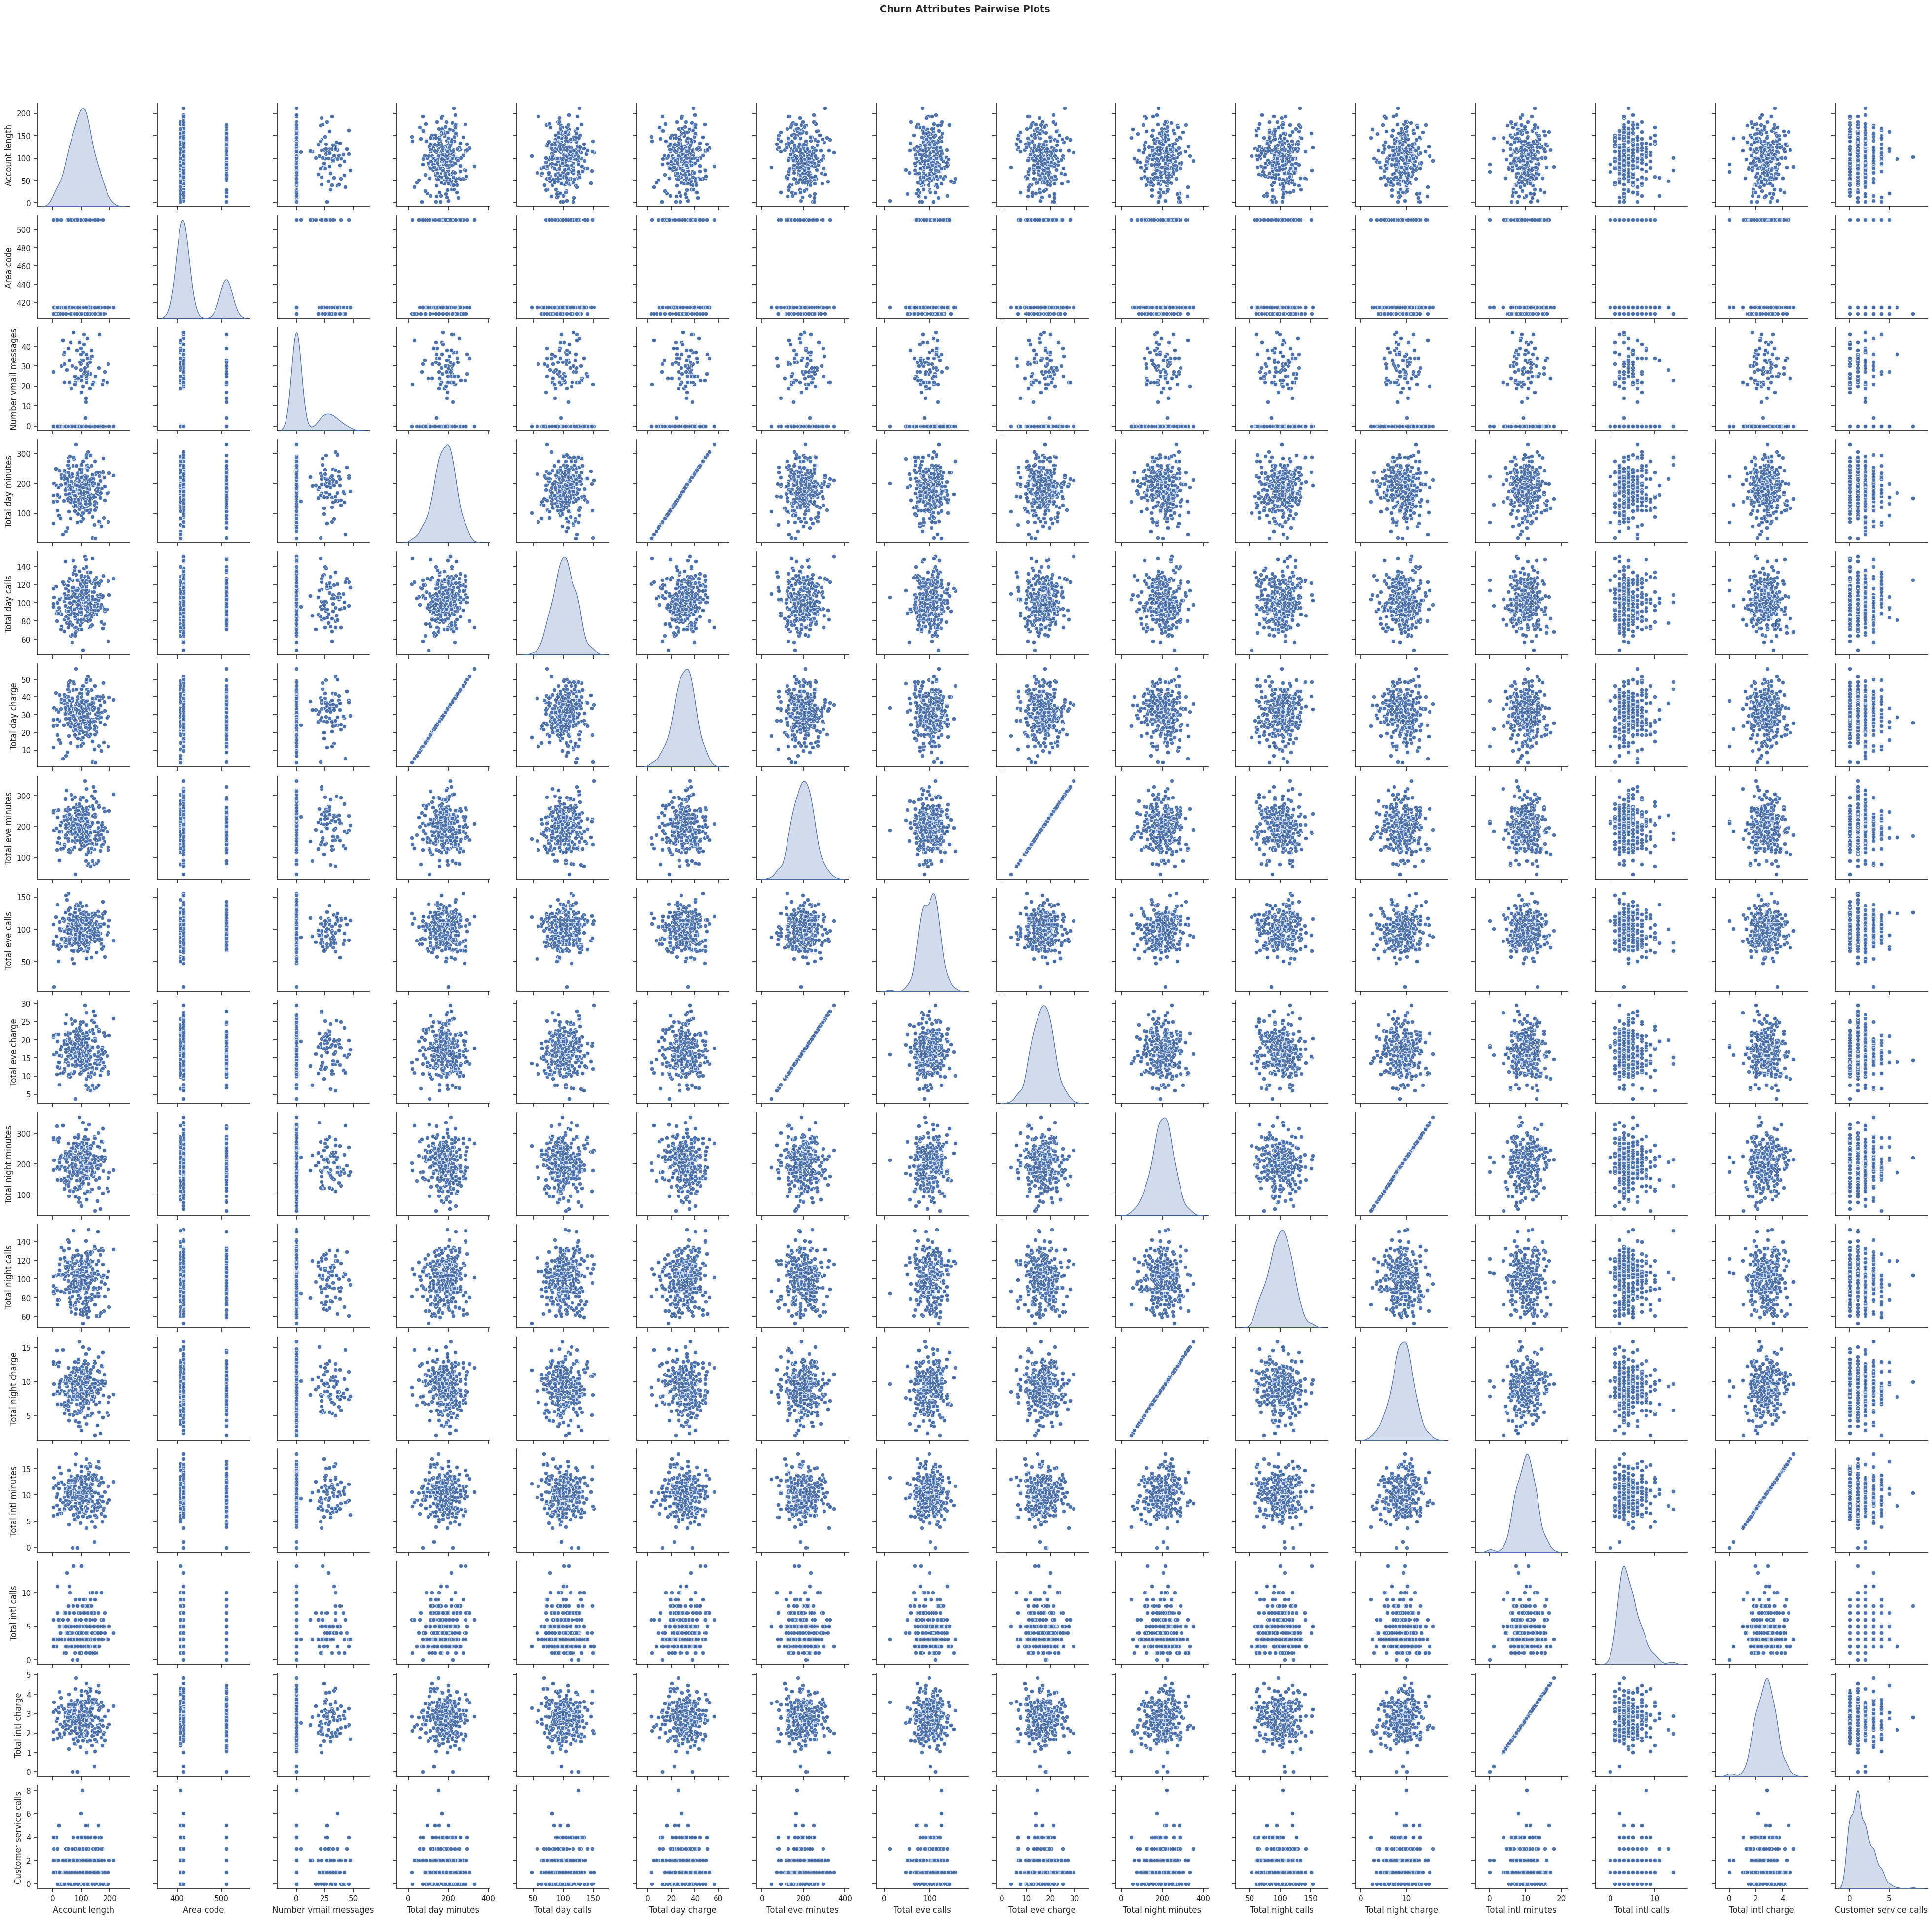

In [ ]:
import seaborn as sns
sns.set(style="ticks")

g = sns.pairplot(sampled_data.toPandas(), diag_kind="kde")
fig = g.fig
fig.subplots_adjust(top=0.93, wspace=0.3)
fig.suptitle('Churn Attributes Pairwise Plots', fontsize=14, fontweight='bold');

It seems that there are several highly correlated fields, *ie* ``Total day minutes`` and ``Total day charge``. Such correlated data will not be very beneficial for the model training runs, so removing them. Doing so by dropping one column of each pair of correlated variables along with the ``State`` and ``Area code`` columns.

Also, transforming the categorical data into numeric as required by the machine learning routines, using a simple user-defined function that maps ``Yes``/``True`` and ``No``/``False`` to ``1`` and ``0``, respectively.

In [ ]:
def get_data(df, removeCols):
    df = df.drop(*removeCols) \
        .withColumn("Churn", when(df["Churn"] == 'true', 1.0).otherwise(0.0)) \
        .withColumn('International plan', when(df["International plan"] == 'Yes', 1.0).otherwise(0.0)) \
        .withColumn('Voice mail plan', when(df["Voice mail plan"] == 'Yes', 1.0).otherwise(0.0))
    return df

In [ ]:
from pyspark.sql.functions import split, col, round, when

removeCols = ['State', 'Area code', 'Total day charge', 'Total eve charge', 'Total night charge', 'Total intl charge']

CV_data = get_data(CV_data, removeCols=removeCols)
final_test_data = get_data(final_test_data, removeCols=removeCols)

Resulting datasets:

In [ ]:
import pandas as pd
pd.DataFrame(CV_data.take(5), columns=CV_data.columns).transpose()

,0,1,2,3,4
Account length,128.0,107.0,137.0,84.0,75.0
International plan,0.0,0.0,0.0,1.0,1.0
Voice mail plan,1.0,1.0,0.0,0.0,0.0
Number vmail messages,25.0,26.0,0.0,0.0,0.0
Total day minutes,265.1,161.6,243.4,299.4,166.7
Total day calls,110.0,123.0,114.0,71.0,113.0
Total eve minutes,197.4,195.5,121.2,61.9,148.3
Total eve calls,99.0,103.0,110.0,88.0,122.0
Total night minutes,244.7,254.4,162.6,196.9,186.9
Total night calls,91.0,103.0,104.0,89.0,121.0


<a id="t5."></a>
## 5. Using Spark MLlib Package

<a id="t5.1."></a>
### 5.1. Decision Tree Models

<a id="t5.2."></a>
### 5.2. Model Training

MLlib classifiers and regressors require data sets in a format of rows of type ``LabeledPoint``, which separates row labels and feature lists, and names them accordingly. Performing the row parsing by the custom ``labelData()`` function, then passing it the prepared data set (``CV_data``) and split it further into training and testing sets. A decision tree classifier model is then generated using the training data, using a ``maxDepth`` of 2, to build a "shallow" tree.

In [ ]:
from pyspark.mllib.regression import LabeledPoint
from pyspark.mllib.tree import DecisionTree

def labelData(data):
    # label: row[end], features: row[0:end-1]
    return data.rdd.map(lambda row: LabeledPoint(row[-1], row[:-1]))

training_data, testing_data = labelData(CV_data).randomSplit([0.8, 0.2])

print("The two first rows of the training data RDD:")
print(training_data.take(2))
print("============================")

model = DecisionTree.trainClassifier(training_data, numClasses=2, maxDepth=2,
                                     categoricalFeaturesInfo={1:2, 2:2},
                                     impurity='gini', maxBins=32)
print(model.toDebugString())

The two first rows of the training data RDD:
[LabeledPoint(0.0, [128.0,0.0,1.0,25.0,265.1,110.0,197.4,99.0,244.7,91.0,10.0,3.0,1.0]), LabeledPoint(0.0, [107.0,0.0,1.0,26.0,161.6,123.0,195.5,103.0,254.4,103.0,13.7,3.0,1.0])]
DecisionTreeModel classifier of depth 2 with 7 nodes
  If (feature 4 <= 265.85)
   If (feature 12 <= 3.5)
    Predict: 0.0
   Else (feature 12 > 3.5)
    Predict: 1.0
  Else (feature 4 > 265.85)
   If (feature 2 in {1.0})
    Predict: 0.0
   Else (feature 2 not in {1.0})
    Predict: 1.0



We can see that features 12 and 4 are used for decision making and should thus be considered as having high predictive power to determine a customer's likeliness to churn.

In [ ]:
print("Feature 12 is the {}.".format(CV_data.columns[12]))
print("Feature 4 is the {}.".format(CV_data.columns[4]))

Feature 12 is the Customer service calls.
Feature 4 is the Total day minutes.


<a id="t5.3."></a>
### 5.3. Model Evaluation


In [ ]:
def printAllMetrics(predictionsDF):
    TP = predictionsDF.select("label", "predictedLabel").filter("label == 1.0 and predictedLabel == 1.0").count()
    FN = predictionsDF.select("label", "predictedLabel").filter("label == 1.0 and predictedLabel == 0.0").count()
    TN = predictionsDF.select("label", "predictedLabel").filter("label == 0.0 and predictedLabel == 0.0").count()
    FP = predictionsDF.select("label", "predictedLabel").filter("label == 0.0 and predictedLabel == 1.0").count()

    precision_p   = TP/(TP+FP)
    precision_n   = TN/(TN+FN)
    recall_p      = TP/(TP+FN)
    recall_n      = TN/(TN+FP)
    f1_p          = 2*precision_p*recall_p/(precision_p+recall_p)
    f1_n          = 2*precision_n*recall_n/(precision_n+recall_n)
    avg_precision = (precision_p*(TP+FN)+precision_n*(TN+FP))/(TP+FN+TN+FP)
    avg_recall    = (recall_p*(TP+FN)+recall_n*(TN+FP))/(TP+FN+TN+FP)
    avg_f1        = (f1_p*(TP+FN)+f1_n*(TN+FP))/(TP+FN+TN+FP)
    accuracy      = (TN+TP)/(TP+FN+TN+FP)

    print('Precision of True    ', precision_p)
    print('Precision of False   ', precision_n)
    print('** Avg Precision     ', avg_precision)
    print('Recall of True       ', recall_p)
    print('Recall of False      ', recall_n)
    print('** Avg Recall        ', avg_recall)
    print('F1 of True           ', f1_p)
    print('F1 of False          ', f1_n)
    print('** Avg F1            ', avg_f1)
    print('** Accuracy          ', accuracy)

Making the predictions of the testing data's churn outcome with the model's ``predict`` function and grouping them together with the actual churn label of each customer data using ``getPredictionsLabels`` function.


In [ ]:
from pyspark.mllib.evaluation import MulticlassMetrics

def getPredictionsLabels(model, test_data):
    predictions = model.predict(test_data.map(lambda r: r.features))
    return predictions.zip(test_data.map(lambda r: r.label))

def printMetrics(predictions_and_labels):
    metrics = MulticlassMetrics(predictions_and_labels)
    print('Confusion Matrix\n', metrics.confusionMatrix().toArray())
    print('Precision of True    ', metrics.precision(1))
    print('Precision of False   ', metrics.precision(0))
    print('Weighted Precision   ', metrics.weightedPrecision)
    print('Recall of True       ', metrics.recall(1))
    print('Recall of False      ', metrics.recall(0))
    print('Weighted Recall      ', metrics.weightedRecall)
    print('FMeasure of True     ', metrics.fMeasure(1.0, 1.0))
    print('FMeasure of False    ', metrics.fMeasure(0.0, 1.0))
    print('Weighted fMeasure    ', metrics.weightedFMeasure())
    print('Accuracy             ', metrics.accuracy)

predictions_and_labels = getPredictionsLabels(model, testing_data)

printMetrics(predictions_and_labels)

/usr/local/lib/python3.10/dist-packages/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


Confusion Matrix
 [[439.  27.]
 [ 42.  28.]]
Precision of True     0.509090909090909
Precision of False    0.9126819126819127
Weighted Precision    0.8599741323621921
Recall of True        0.4
Recall of False       0.9420600858369099
Weighted Recall       0.871268656716418
FMeasure of True      0.44799999999999995
FMeasure of False     0.9271383315733898
Weighted fMeasure     0.8645642957335814
Accuracy              0.871268656716418


Confusion Matrix:

In [ ]:
predictionsdf = predictions_and_labels.toDF(["predictedLabel","label"])

predictionsdf.groupBy('label', 'predictedLabel').count().show()
print("========================================")

printAllMetrics(predictionsdf)

+-----+--------------+-----+
|label|predictedLabel|count|
+-----+--------------+-----+
|  1.0|           1.0|   29|
|  0.0|           1.0|   26|
|  1.0|           0.0|   42|
|  0.0|           0.0|  439|
+-----+--------------+-----+

Precision of True     0.5454545454545454
Precision of False    0.9126819126819127
** Avg Precision      0.8633528633528633
Recall of True        0.4166666666666667
Recall of False       0.9461206896551724
** Avg Recall         0.875
F1 of True            0.47244094488188976
F1 of False           0.9291005291005291
** Avg F1             0.8677581968920551
** Accuracy           0.875


The ``FMesure`` given by the ``MulticlassMetrics`` is none other than the known classical ``F1`` metric.

The overall ``Accuracy``, seems quite good, but one troubling issue is the discrepancy between the recall measures. The ``recall`` (aka sensitivity) for the ``Churn=False`` samples is high, while the recall for the Churn=True examples is relatively low. Business decisions made using these predictions will be used to retain the customers most likely to leave, not those who are likely to stay. Thus, it is needed to be ensured that the model is sensitive to the ``Churn=True`` samples.

The model's sensitivity bias toward ``Churn=False`` samples is due to a skewed distribution of the two types of samples. Let's try grouping the ``CV_data`` DataFrame by the ``Churn`` field and counting the number of instances in each group.

In [ ]:
CV_data.groupby('Churn').count().show()

+-----+-----+
|Churn|count|
+-----+-----+
|  0.0| 2278|
|  1.0|  388|
+-----+-----+



<a id="t5.4."></a>
### 5.4. Stratified Sampling

There are roughly 6 times as many False churn samples as True churn samples. Putting the two sample types on the same footing using stratified sampling. The DataFrames ``sampleBy`` function does this when provided with fractions of each sample type to be returned.

Keeping all instances of the ``Churn=True`` class, but downsampling the Churn=False class to a fraction of ``388/2278``.

In [ ]:
stratified_CV_data = CV_data.sampleBy('Churn', fractions={0: CV_data.select("Churn").where('Churn == 1').count()/
                                                          CV_data.select("Churn").where('Churn == 0').count(), 1: 1.0}, seed = 5323)

stratified_CV_data.groupby('Churn').count().show()

+-----+-----+
|Churn|count|
+-----+-----+
|  0.0|  388|
|  1.0|  388|
+-----+-----+



Building a new model using the evenly distributed data set and seeing how it performs.

In [ ]:
training_data, testing_data = labelData(stratified_CV_data).randomSplit([0.8, 0.2])

model = DecisionTree.trainClassifier(training_data, numClasses=2, maxDepth=2,
                                     categoricalFeaturesInfo={1:2, 2:2},
                                     impurity='gini', maxBins=32)

predictions_and_labels = getPredictionsLabels(model, testing_data)
printMetrics(predictions_and_labels)

print("========================================")

predictionsdf = predictions_and_labels.toDF(["predictedLabel","label"])
printAllMetrics(predictionsdf)

Confusion Matrix
 [[50.  5.]
 [31. 35.]]
Precision of True     0.875
Precision of False    0.6172839506172839
Weighted Precision    0.7578563411896745
Recall of True        0.5303030303030303
Recall of False       0.9090909090909091
Weighted Recall       0.7024793388429752
FMeasure of True      0.660377358490566
FMeasure of False     0.7352941176470589
Weighted fMeasure     0.6944304308344265
Accuracy              0.7024793388429752
Precision of True     0.875
Precision of False    0.5952380952380952
** Avg Precision      0.7509120583717358
Recall of True        0.5072463768115942
Recall of False       0.9090909090909091
** Avg Recall         0.6854838709677419
F1 of True            0.6422018348623854
F1 of False           0.7194244604316546
** Avg F1             0.6764538058810129
** Accuracy           0.6854838709677419


With these new recall values, it is evident that the stratified data was helpful in building a less biased model, which will ultimately provide more generalized and robust predictions.

<a id="t6."></a>
## 6. Using Spark ML Package


<a id="t6.1."></a>
### 6.1. Pipelining

The ML package needs data be put in a (``label: Double, features: Vector``) DataFrame format with correspondingly named fields using the ``VectorAssembler`` function. The global ``get_dummy`` function defined below performs this formatting in which the data is also passed through a pipeline of two transformers, ``StringIndexer`` and ``VectorIndexer`` which index the label and features fields respectively.

<a id="t6.2."></a>
### 6.2. Model Selection

The ML package supports k-fold cross validation, which can be readily coupled with a parameter grid builder and an evaluator to construct a model selection workflow. Below, a transformation/estimation pipeline is used to train the classifier models.
The cross validator used below is an empty ``ParamGridBuilder`` to iterate through the default parameters of the studied classifiers and evaluate their models using the ``F1 score``, repeating 3 times per default parameter value for reliable results.

Firstly, the ``stratified_CV_data`` dataframe form:

In [ ]:
stratified_CV_data.show(2)

+--------------+------------------+---------------+---------------------+-----------------+---------------+-----------------+---------------+-------------------+-----------------+------------------+----------------+----------------------+-----+
|Account length|International plan|Voice mail plan|Number vmail messages|Total day minutes|Total day calls|Total eve minutes|Total eve calls|Total night minutes|Total night calls|Total intl minutes|Total intl calls|Customer service calls|Churn|
+--------------+------------------+---------------+---------------------+-----------------+---------------+-----------------+---------------+-------------------+-----------------+------------------+----------------+----------------------+-----+
|           118|               1.0|            0.0|                    0|            223.4|             98|            220.6|            101|              203.9|              118|               6.3|               6|                     0|  0.0|
|            73|    

Defining a ``get_dummy`` function that transforms a given classical dataframe to a new other one composed of dense vectors reliable to be running with Spark ML.

In [ ]:
from pyspark.ml.feature import StringIndexer, VectorIndexer, VectorAssembler
from pyspark.ml import Pipeline

def get_dummy(df, numericCols, labelCol):
    # Combining a given list of columns into a single vector column features
    assembler = VectorAssembler(inputCols=numericCols, outputCol="features")

    # Index labels, adding metadata to the label column
    indexer = StringIndexer(inputCol=labelCol, outputCol='indexedLabel')

    # Automatically identify categorical features and index them
    featureIndexer = VectorIndexer(inputCol="features", outputCol="indexedFeatures", maxCategories=2)

    pipeline = Pipeline(stages = [assembler] + [indexer] + [featureIndexer])

    model = pipeline.fit(df)
    data = model.transform(df)

    data = data.withColumn('label', col(labelCol))

    return data.select('features', 'label', 'indexedFeatures', 'indexedLabel')

Once the required function is ready, defining the needed ``numericCols`` list by removing the ``Churn`` column and transforming the datasets:

In [ ]:
numericCols = stratified_CV_data.columns
numericCols.remove("Churn")

vectorized_CV_data = get_dummy(CV_data, numericCols, "Churn")
vectorized_stratified_CV_data = get_dummy(stratified_CV_data, numericCols, "Churn")
vectorized_final_test_data = get_dummy(final_test_data, numericCols, "Churn")

Structure of one of the transformed datasets to see what has been happened by comparing it to the structure displayed above:

In [ ]:
vectorized_stratified_CV_data.show(2, False)

+------------------------------------------------------------------+-----+------------------------------------------------------------------+------------+
|features                                                          |label|indexedFeatures                                                   |indexedLabel|
+------------------------------------------------------------------+-----+------------------------------------------------------------------+------------+
|[118.0,1.0,0.0,0.0,223.4,98.0,220.6,101.0,203.9,118.0,6.3,6.0,0.0]|0.0  |[118.0,1.0,0.0,0.0,223.4,98.0,220.6,101.0,203.9,118.0,6.3,6.0,0.0]|0.0         |
|[73.0,0.0,0.0,0.0,224.4,90.0,159.5,88.0,192.8,74.0,13.0,2.0,1.0]  |0.0  |[73.0,0.0,0.0,0.0,224.4,90.0,159.5,88.0,192.8,74.0,13.0,2.0,1.0]  |0.0         |
+------------------------------------------------------------------+-----+------------------------------------------------------------------+------------+
only showing top 2 rows



<a id="t6.3."></a>
### 6.3. K-fold cross validation

Defining below a ``cvComparing`` function in order to compute the cross validation procedures and keeping all the necessary metrics during the training as well as the test steps. In order to make the results more readable, rounding the metrics by specifying the number of decimal places.

In [ ]:
def cvComparing(vectorized_train_data, vectorized_test_data, classifiers, paramGrid, numFolds, roundLevel, seed):
    names = []
    underROC_train = []
    underROC_test = []
    f1_train = []
    f1_test = []
    wp_train = []
    wp_test = []
    wr_train = []
    wr_test = []
    acc_train = []
    acc_test = []

    evaluatorB = BinaryClassificationEvaluator(rawPredictionCol="prediction", labelCol="indexedLabel")

    evaluatorf1 = MulticlassClassificationEvaluator(labelCol="indexedLabel", predictionCol="prediction", metricName="f1")
    evaluatorwp = MulticlassClassificationEvaluator(labelCol="indexedLabel", predictionCol="prediction", metricName="weightedPrecision")
    evaluatorwr = MulticlassClassificationEvaluator(labelCol="indexedLabel", predictionCol="prediction", metricName="weightedRecall")
    evaluatoracc = MulticlassClassificationEvaluator(labelCol="indexedLabel", predictionCol="prediction", metricName="accuracy")

    for name, clf in classifiers:
        cv = CrossValidator(estimator=clf, estimatorParamMaps=paramGrid, evaluator=evaluatorf1, numFolds=numFolds, seed=seed, collectSubModels=True)
        cvModel = cv.fit(vectorized_train_data)
        predict_train = cvModel.transform(vectorized_train_data)
        predict_test = cvModel.transform(vectorized_test_data)
        underROC_train.append(evaluatorB.evaluate(predict_train))
        underROC_test.append(evaluatorB.evaluate(predict_test))
        f1_train.append(evaluatoracc.evaluate(predict_train))
        f1_test.append(evaluatoracc.evaluate(predict_test))
        wp_train.append(evaluatorwp.evaluate(predict_train))
        wp_test.append(evaluatorwp.evaluate(predict_test))
        wr_train.append(evaluatorwr.evaluate(predict_train))
        wr_test.append(evaluatorwr.evaluate(predict_test))
        acc_train.append(evaluatoracc.evaluate(predict_train))
        acc_test.append(evaluatoracc.evaluate(predict_test))
        names.append(name)

    cvResults = spark.createDataFrame(zip(names, underROC_train, underROC_test, acc_train, acc_test, f1_train, f1_test, wp_train, wp_test, wr_train, wr_test),
                                       schema=['Classifier name', 'underROC_train', 'underROC_test', 'Accuracy_train', 'Accuracy_test', 'f1_train', 'f1_test', 'wPrecision_train', 'wPrecision_test', 'wRecall_train', 'wRecall_test'])

    for t in cvResults.dtypes:
        if t[1] == 'double':
            cvResults = cvResults.withColumn(t[0], round(cvResults[t[0]], roundLevel))

    return cvResults

In [ ]:
from pyspark.ml.classification import LogisticRegression, NaiveBayes, LinearSVC, DecisionTreeClassifier, RandomForestClassifier, GBTClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

paramGrid = ParamGridBuilder().build()

classifiers = []
##############################################
classifiers.append(('LR', LogisticRegression(labelCol='indexedLabel', featuresCol='indexedFeatures')))
classifiers.append(('NB', NaiveBayes(labelCol='indexedLabel', featuresCol='indexedFeatures')))
classifiers.append(('SVC', LinearSVC(labelCol='indexedLabel', featuresCol='indexedFeatures')))
classifiers.append(('DT', DecisionTreeClassifier(labelCol='indexedLabel', featuresCol='indexedFeatures')))
classifiers.append(('RF', RandomForestClassifier(labelCol='indexedLabel', featuresCol='indexedFeatures')))
classifiers.append(('GBT', GBTClassifier(labelCol='indexedLabel', featuresCol='indexedFeatures')))
##############################################


cvResults_CV_data = cvComparing(vectorized_train_data=vectorized_CV_data, vectorized_test_data=vectorized_final_test_data,
                                classifiers=classifiers, paramGrid=paramGrid, numFolds=5, roundLevel=3, seed=123)

cvResults_stratified_CV_data = cvComparing(vectorized_train_data=vectorized_stratified_CV_data,
                                           vectorized_test_data=vectorized_final_test_data, classifiers=classifiers,
                                           paramGrid=paramGrid, numFolds=5, roundLevel=3, seed=123)

<a id="t6.4."></a>
### 6.4. Model Evaluation

The actual performance of the models is determined based on both ``CV_data`` and ``stratified_CV_data`` as well as ``final_test_data`` sets. The last one has not been used for any training or cross validation activities. Transforming the test set with the model pipeline, which will map the labels and features according to the same recipe. The evaluators will provide all the metrics of the ``MulticlassClassificationEvaluator`` function as well as the Area Under ROC (``underRoc``) metric based on the ``BinaryClassificationEvaluator`` obtained from the predictions during the training and the test steps. These metrics are computed using the above studied classifiers with its default parameters accross 5-fold cross validation by trying to find the best value of the ``F1`` metric.

**Metrics computed using all the data of ``CV_data`` for the training step:**

In [ ]:
cvResults_CV_data.toPandas().set_index('Classifier name')

,underROC_train,underROC_test,Accuracy_train,Accuracy_test,f1_train,f1_test,wPrecision_train,wPrecision_test,wRecall_train,wRecall_test
Classifier name,,,,,,,,,,
LR,0.597,0.577,0.863,0.855,0.863,0.855,0.835,0.820,0.863,0.855
NB,0.610,0.610,0.632,0.625,0.632,0.625,0.800,0.804,0.632,0.625
SVC,0.500,0.500,0.854,0.858,0.854,0.858,0.730,0.735,0.854,0.858
DT,0.841,0.818,0.948,0.945,0.948,0.945,0.948,0.945,0.948,0.945
RF,0.791,0.783,0.935,0.930,0.935,0.930,0.935,0.927,0.935,0.930
GBT,0.921,0.859,0.976,0.954,0.976,0.954,0.976,0.953,0.976,0.954


**Metrics computed using the stratified data (``stratified_CV_data``) for the training step:**

In [ ]:
cvResults_stratified_CV_data.toPandas().set_index('Classifier name')

,underROC_train,underROC_test,Accuracy_train,Accuracy_test,f1_train,f1_test,wPrecision_train,wPrecision_test,wRecall_train,wRecall_test
Classifier name,,,,,,,,,,
LR,0.776,0.750,0.776,0.751,0.776,0.751,0.776,0.860,0.776,0.751
NB,0.602,0.607,0.602,0.537,0.602,0.537,0.603,0.810,0.602,0.537
SVC,0.780,0.765,0.780,0.763,0.780,0.763,0.780,0.866,0.780,0.763
DT,0.899,0.848,0.899,0.928,0.899,0.928,0.912,0.927,0.899,0.928
RF,0.876,0.808,0.876,0.822,0.876,0.822,0.878,0.884,0.876,0.822
GBT,0.947,0.862,0.947,0.921,0.947,0.921,0.952,0.925,0.947,0.921


According to the above two plots, we cannot confirm that the data stratification is a good idea that can improve the learning. The metrics computed using all the data are higher than those obtained with the stratified data. This implies that the stratified data are poorly and cannot goodly cover all the situations present in global data. It is clear that the Decision tree, Random forest and Gradient-boosted tree are the more efficient classifiers. However, it seems that the Decision tree is the best classifier because all its metrics are close to each other for the two situations of data.

**Comparison of the metric values given by the ``printAllMetrics`` function with those obtained using ``MulticlassClassificationEvaluator``:**


In [ ]:
evaluatorf1 = MulticlassClassificationEvaluator(labelCol="indexedLabel", predictionCol="prediction", metricName="f1")
evaluatorwp = MulticlassClassificationEvaluator(labelCol="indexedLabel", predictionCol="prediction", metricName="weightedPrecision")
evaluatorwr = MulticlassClassificationEvaluator(labelCol="indexedLabel", predictionCol="prediction", metricName="weightedRecall")
evaluatorac = MulticlassClassificationEvaluator(labelCol="indexedLabel", predictionCol="prediction", metricName="accuracy")

#clf = DecisionTreeClassifier(labelCol='indexedLabel', featuresCol='indexedFeatures')
clf = NaiveBayes(labelCol='indexedLabel', featuresCol='indexedFeatures')

clfModel = clf.fit(vectorized_stratified_CV_data)
pred_train = clfModel.transform(vectorized_stratified_CV_data)

print('Weighted Precision   ', evaluatorwp.evaluate(pred_train))
print('Weighted Recall      ', evaluatorwr.evaluate(pred_train))
print('F1                   ', evaluatorf1.evaluate(pred_train))
print('Accuracy             ', evaluatorac.evaluate(pred_train))

print("========================================")

printAllMetrics(pred_train.withColumn('predictedLabel', col("prediction")))

Weighted Precision    0.6033201874136246
Weighted Recall       0.6018041237113402
F1                    0.6003380185910225
Accuracy              0.6018041237113402
Precision of True     0.5908045977011495
Precision of False    0.6158357771260997
** Avg Precision      0.6033201874136246
Recall of True        0.6623711340206185
Recall of False       0.5412371134020618
** Avg Recall         0.6018041237113402
F1 of True            0.6245443499392467
F1 of False           0.5761316872427983
** Avg F1             0.6003380185910225
** Accuracy           0.6018041237113402


The MetricName used by ``BinaryClassificationEvaluator`` function has not been defined. Seeing its default value:

In [ ]:
print("The metric name used by the BinaryClassificationEvaluator is {}.".format(BinaryClassificationEvaluator().getMetricName()))

The metric name used by the BinaryClassificationEvaluator is areaUnderROC.


<a id="t7."></a>
## 7. Conclusion

The Decision tree, Random forest and Gradient-boosted tree are the more efficient classifiers. However, the best model created according to the cross validation process seems to be the Decision tree. Indeed, the different metrics obtained by using this classifier are higher as well as very close to each other comparing to those of the other classifiers. An explication on how to compute all the different metrics excepting both area under ROC and area under PR is given in a function called ``printAllMetrics``.